<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_08%5DCreate_a_Korean_English_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_08]Create a Korean-English translator

## 1. import 및 라이브러리 로드

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [2]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-14 04:34:47--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-14 04:34:48--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9b925593cb002f9155799224d4.dl.dropboxusercontent.com/cd/0/get/BuwlSoyhiPc00e6_sZX1pDEUmVm2zPWexKovBy93otgjZZ1ncVAMouLPTf8IsDYSoUUpcFT-filHvD__plOMDjVoBlptoIfUOaDnqwvN243dpcW8142aVJ1rlwMuxgbxF_gYjs55Qx11k2Q4gR0jAPJwVIRvL0SEEVH9gDEha_y-EUyEzS_wJ41x2lV3Y2P7JwI/file?dl=1# [following]
--2022-10-14 04:34:48--  https://uc9b925593cb002f9155799224d4.dl.dropboxusercontent.com/cd/0/get/BuwlSoyhiPc0

In [3]:
import urllib.request
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
mecab = Mecab()
plt.rc('font', family='NanumBarunGothic')

## 2. 데이터 다운로드

In [4]:
path_train_ko = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/translator_ke/korean-english-park.train.ko'
path_train_en = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/translator_ke/korean-english-park.train.en'

In [5]:
# with open(path_train_ko, "r") as f:
#     raw_ko = f.read().splitlines()

# print("Data Size:", len(raw_ko))
# print("Example:")

# for sen in raw_ko[0:100][::20]: print(">>", sen)

In [6]:
# with open(path_train_en, "r") as f:
#     raw_en = f.read().splitlines()

# print("Data Size:", len(raw_en))
# print("Example:")

# for sen in raw_en[0:100][::20]: print(">>", sen)

## 3. 데이터 정제

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3. 타겟 언어인 영문엔 start 토큰과 end 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

In [7]:
# cleaned_corpus = list(set(zip(raw_ko, raw_en)))

In [8]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(path_train_ko, path_train_en)

In [9]:
len(cleaned_corpus)

78968

전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 

In [10]:
def preprocess_sentence(sentence, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    # 전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다.   
    if e_token == True:
        sentence = '<start> ' + sentence
        sentence += ' <end>'
        sentence = sentence.split()
    else: #  Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않다.
        sentence = mecab.morphs(sentence)

    
    return sentence

In [11]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])

('이 이외에도 우리의 미식축구에 대한 깊은 애정 때문도 있습니다.”', 'and besides, our deep love of football.')
pair 0 : 이 이외에도 우리의 미식축구에 대한 깊은 애정 때문도 있습니다.”
pair 1 : and besides, our deep love of football.
('그는 이 “선의의 행동”을 압바스를 비롯하여 이집트와 요르단의 지도자들이 참석한 가운데 이집트에서 열린 정상회담에서 발표하였다.', 'He announced the “goodwill gesture” at a summit in Egypt, attended by Abbas and the leaders of Egypt and Jordan.')
pair 0 : 그는 이 “선의의 행동”을 압바스를 비롯하여 이집트와 요르단의 지도자들이 참석한 가운데 이집트에서 열린 정상회담에서 발표하였다.
pair 1 : He announced the “goodwill gesture” at a summit in Egypt, attended by Abbas and the leaders of Egypt and Jordan.
('이곳의 눈은 98퍼센트의 물과 2퍼센트의 화학물질을 섞어 만들었지만 인체에 전혀 유해하지 않다.', "It's made from 98 percent water and 2 percent chemical solution that is harmless.")
pair 0 : 이곳의 눈은 98퍼센트의 물과 2퍼센트의 화학물질을 섞어 만들었지만 인체에 전혀 유해하지 않다.
pair 1 : It's made from 98 percent water and 2 percent chemical solution that is harmless.
('루이스 이나시우 룰라 다 실바 브라질 대통령은 “중남미 국가들간의 강력하고 연합된 중남미기구가 정당화됐다”며 “이는 중남미 대륙 국가들이 처음으로 통제하는 국제 금융기구가 될 것”이라고 말했다.', '"Only strong an

원활한 학습을 위해 데이터는 상위 2만 개만 사용하도록 하겠습니다.

In [12]:
enc_corpus = []
dec_corpus = []

num_examples = 20000

for pair in cleaned_corpus[:num_examples]:
    enc_pre = preprocess_sentence(pair[0])
    dec_pre = preprocess_sentence(pair[1],  e_token=True)
    if len(enc_pre) <= 40 and len(dec_pre) <= 40:
        enc_corpus.append(enc_pre)
        dec_corpus.append(dec_pre)

print("한국어:", enc_corpus[100])   # go away !
print("영어:", dec_corpus[100])   # <start> salga de aqu ! <end>

한국어: ['그', '는', '위험', '이', '존재', '한다', '고', '말', '했', '다', '.']
영어: ['<start>', 'the', 'threat', 'exists', ',', 'he', 'said', '.', '<end>']


## 4. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환하세요. 그리고 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리한다.

In [13]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [14]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("한국어 Vocab Size:", len(enc_tokenizer.index_word))
print("영어 Vocab Size:", len(dec_tokenizer.index_word))

한국어 Vocab Size: 24174
영어 Vocab Size: 21741


## 5. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

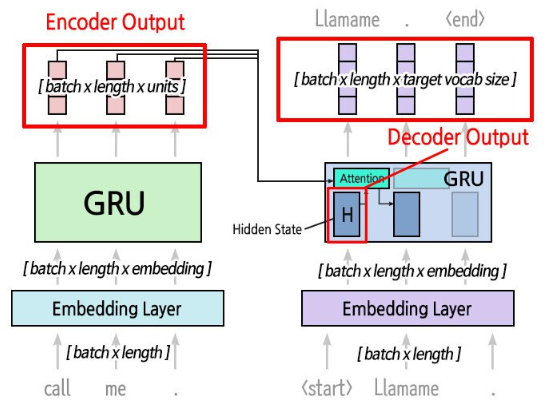

>Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어낸다.

>Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

>여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 21742)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


## 6. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

❕ 참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

>Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법 정도로 설명할 수 있다.  여기서 fit() 함수를 사용할 수 없는 이유는 바로 Loss 함수 때문입니다. 앞서 설명한 것처럼 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하기 때문이다.

>SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해줍니다. CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. 우리는 True 로 줬으니 모델의 출력값을 그대로 전달하면 됩니다!

>데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 패딩(Padding) 과정을 거친 것을 기억하나요? tokenize() 함수 내부의 pad_sequences() 가 바로 그 역할을 해주는 녀석이다.

>고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 <PAD> 토큰만을 생성할 확률이 굉장히 높아집니다. 이 문제를 방지하기 위해 mask 가 사용됩니다! mask 는 정답지에서 <PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠. equal() 함수에 정확히는 0 이 아닌 <PAD> 토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


>@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이죠! 실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다!
- 오토그래프 공식 문서 :  https://www.tensorflow.org/guide/function?hl=ko

>tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프 이다.
- 그래디언트 및 자동 미분 소개 : https://www.tensorflow.org/guide/autodiff?hl=ko

>train_step()의 학습 과정은 아래와 같습니다.
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 start 토큰 문장 생성
4. start 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

In [20]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리 : https://github.com/tqdm/tqdm

In [21]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 50: 100%|██████████| 198/198 [00:15<00:00, 12.83it/s, Loss 1.5576]


In [22]:
def preprocess_sentence2(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence2(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

def translate_character(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

## 7. 결과 확인하기

In [23]:
print(translate_character("오바마는 대통령이다.", encoder, decoder))
print('--------------------------------------------')
print(translate_character("시민들은 도시 속에 산다.", encoder, decoder))
print('--------------------------------------------')
print(translate_character("커피는 필요 없다.", encoder, decoder))
print('--------------------------------------------')
print(translate_character("일곱 명의 사망자가 발생했다.", encoder, decoder))

Input: 오바마는 대통령이다 .
Predicted translation: they re a lot of the first time . <end> 
None
--------------------------------------------
Input: 시민들은 도시 속에 산다 .
Predicted translation: the best way as a lot of the best way as a lot of the best way as a lot of the best way as a lot of the best way as a lot of the best way as a 
None
--------------------------------------------
Input: 커피는 필요 없다 .
Predicted translation: the party s not just a lot that we have always looking by the first time it s not just a lot that we have always looking by the first time it s not just a lot that we have 
None
--------------------------------------------
Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: according to the first time of violence . <end> 
None


Input: 오바마는 대통령이다 .
Predicted translation: they re a lot of the first time . <end> 


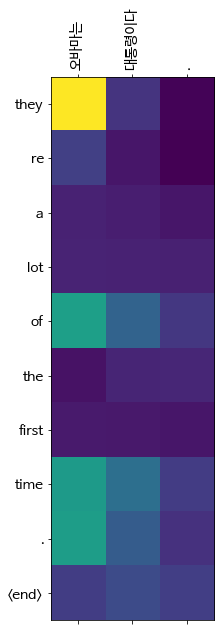

In [24]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the best way as a lot of the best way as a lot of the best way as a lot of the best way as a lot of the best way as a lot of the best way as a 


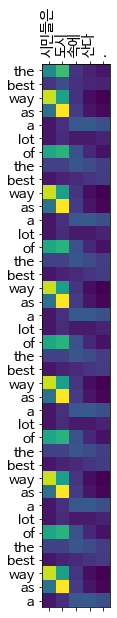

In [25]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: the party s not just a lot that we have always looking by the first time it s not just a lot that we have always looking by the first time it s not just a lot that we have 


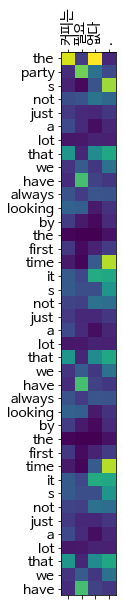

In [26]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: according to the first time of violence . <end> 


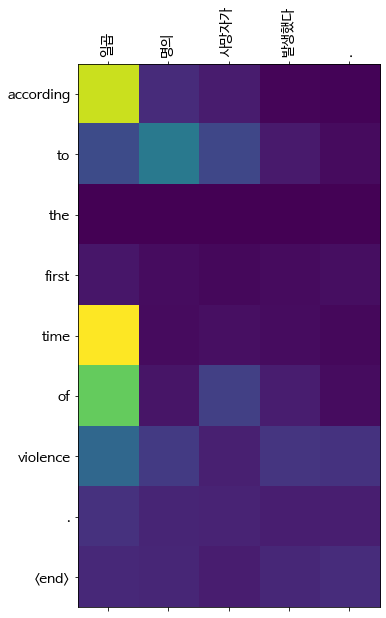

In [27]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

## 8. 회고
- 어려웠던 점
  - 번역 결과가 계속해서 좋지 않았다. epoch도 조정해보고, 여러가지의 파라미터도 조정해보았지만 여전히 성능은 좋지 않다.
  - LMS와 데이터가 달라서 데이터를 정제하는 데 애를 먹었다. 나는 list(set(zip()))를 사용하였다. 파이썬 기본 문법에 대한 이해도를 높일 필요가 있다.
- 루브릭 기준을 맞추기 위하여 시도한 것
  - Attentional Seq2Seq가 정상적으로 동작하고 있다. training loss가 점점 줄어들어 최종 결과에서는 0.9까지 떨어졌다.
  - 구두점, 대소문자, 띄어쓰기, Mecab를 활용한 전처리를 정상적으로 진행하였다.
  - 마지막 루브릭 기준인 의미가 통하는 수준의 번역문은 생성되지 못하였다. 부분 부분적으로 단어의 뜻은 일치하지만 문맥으로 보았을 때는 제대로 번역이 되지 못한 것 같다.
- 시도해본 것
  - 다양한 파라미터를 조정하였으나 좀 처럼 성능이 오르지 않아 애를 먹었다.
- 공부하게 된 것
  - 왜 트랜스포머가 나오게 된지 알 것 같다. 추후 트랜스포머와 이를 기반으로한 BERT학습에 혼신을 다해야 겠다.

## 9. 루브릭 기준
|평가항목|상세기준
|-------------------|--------------|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.| seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|